In [3]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt

d2l.use_svg_display() # 使用矢量图显示

## 读取数据集
我们可以通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中。

In [4]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



Fashion-MNIST由10个类别的图像组成， 每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。 因此，训练集和测试集分别包含60000和10000张图像。 测试数据集不会用于训练，只用于评估模型性能。

In [5]:
len(mnist_train), len(mnist_test)

(60000, 10000)

每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1。 为了简洁起见，本书将高度$h$像素、宽度$w$像素图像的形状记为$h * w$或$(h,w)$

In [6]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。 以下函数用于在数字标签索引及其文本名称之间进行转换。

In [7]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。  

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale) # 设置子图大小
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize) # 生成子图
    axes = axes.flatten() # 将子图展平
    # 对子图进行迭代，绘制图片和设置标题
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前几个样本的图像及其相应的标签。

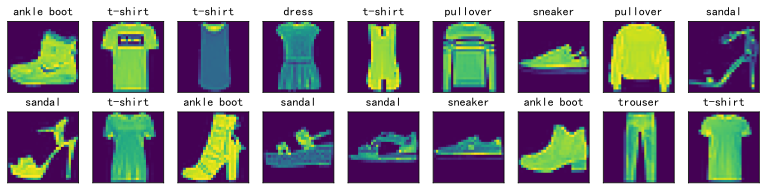

In [14]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18))) # next(iter())返回迭代器的下一个项目
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y)); # 展示图片

## 读取小批量
为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建。 回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为batch_size。 通过内置数据迭代器，我们可以随机打乱了所有样本，从而无偏见地读取小批量。

In [15]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

我们看一下读取训练数据所需的时间。

In [16]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'4.02 sec'

## 整合所有组件
现在我们定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集。 这个函数返回训练集和验证集的数据迭代器。 此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

In [17]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

下面，我们通过指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能。

In [18]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64
